# Training Norm-reference encoding on FERG dataset

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import tensorflow as tf

from utils.load_config import load_config
from utils.load_data import load_data
from utils.extraction_model import load_extraction_model

np.random.seed(0)
np.set_printoptions(precision=3, suppress=True, linewidth=150)

### declare parameters

In [10]:
# define configuration
config_path = 'NR_02_FERG_m0001.json'

# load config
config = load_config(config_path, path='../../configs/norm_reference')

In [3]:
### Load training data
train_data = load_data(config)
print("shape train_data[0]", np.shape(train_data[0]))

100%|██████████| 2000/2000 [00:03<00:00, 501.51it/s]


shape train_data[0] (2000, 224, 224, 3)


In [34]:
def display_image(image, lmks=None, ref_lmks=None, lmk_size=5, figure=None):
    img = np.copy(image)
    # (un-)process image from VGG19 pre-processing
    img = np.array(img + 128) / 256
    img = img[..., ::-1]  # rgb
    img[img > 1] = 1.0

    # compute padding
    lmk_padding = int(lmk_size/2)

    if ref_lmks is not None:
        # add lmk on image
        ref_lmks = np.array(ref_lmks).astype(int)
        for r_lmk in ref_lmks:
            img[r_lmk[1]-lmk_padding:r_lmk[1]+lmk_padding, r_lmk[0]-lmk_padding:r_lmk[0]+lmk_padding] = [0, 1, 0]

    if lmks is not None:
        # add lmk on image
        lmks = np.array(lmks).astype(int)
        for lmk in lmks:
            img[lmk[1]-lmk_padding:lmk[1]+lmk_padding, lmk[0]-lmk_padding:lmk[0]+lmk_padding] = [0, 1, 1]

    if figure is None:
        plt.figure()
        plt.imshow(img)
    else:
        figure.imshow(img)

In [35]:
def display_images(images, lmks=None, ref_lmks=None, n_max_col=7, size_img=4, lmk_size=5):
    n_image = len(images)

    # compute n_row and n_column
    n_col = np.min([n_max_col, n_image])
    n_row = int(n_image / n_col)

    # declare figure
    fig, axs = plt.subplots(n_row, n_col)
    fig.set_figheight(n_row*size_img)
    fig.set_figwidth(n_col*size_img)

    lmk_pos = None

    for i in range(n_row):
        for j in range(n_col):
            img_idx = i * n_col + j

            if lmks is not None:
                lmk_pos = lmks[img_idx]

            if n_row == 1 and n_col == 1:
                display_image(images[img_idx], lmks=lmk_pos, ref_lmks=ref_lmks, lmk_size=lmk_size, figure=axs)
            elif n_row == 1:
                display_image(images[img_idx], lmks=lmk_pos, ref_lmks=ref_lmks, lmk_size=lmk_size, figure=axs[img_idx])
            else:
                display_image(images[img_idx], lmks=lmk_pos, ref_lmks=ref_lmks, lmk_size=lmk_size, figure=axs[i, j])

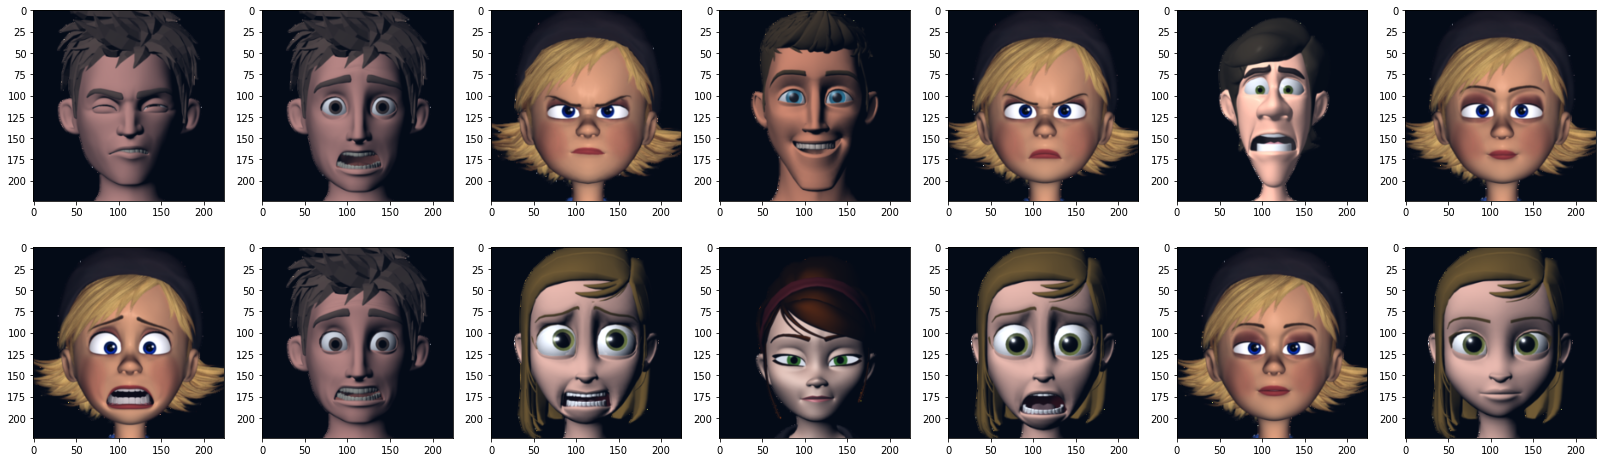

In [36]:
display_images(train_data[0][:14], n_max_col=7)

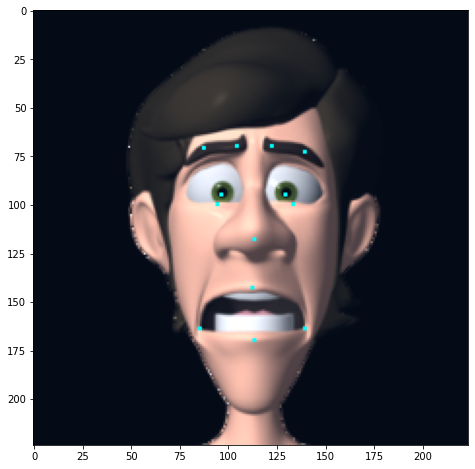

In [213]:
# create labeling
im_idx = 5

# l_eye, r_eye, nose, l_eyebrow_ext, l_eyebrow_int, r_eyebrow_int, r_eyebrow_ext,
# l_corner_mouth, up_mouth, r_corner_mouth, lower_mouth,
# l_lower_eyelid, r_lower_eyelid

# [x, y] -> [horizontal, vertical]
lmk_pos = [[[[85, 112], [142, 112], [114, 144], [74, 94], [102, 101], [125, 100], [155, 94], [90, 169], [114, 160], [136, 167], [115, 175], [83, 113],            [143, 114]]],  # 0 Ray
           [[[86, 114], [142, 114], [114, 148], [67, 89], [100, 80], [128, 80], [160, 89], [86, 184], [114, 165], [140, 184], [114, 193], [82, 124], [145, 124]]],  # 1 Ray
           [[[91, 117], [137, 117], [114, 142], [70, 101], [100, 112], [130, 112], [160, 101], [95, 167], [114, 161], [131, 167], [114, 170], [83, 128], [145, 128]]],  # 2 Bonnie
           [[[88, 103], [139, 103], [114, 139], [74, 74], [99, 75], [128, 75], [154, 74], [85, 154], [114, 154], [145, 151], [114, 174], [84, 110], [142, 110]]],  # 3 Jules
           [[[91, 117], [137, 117], [114, 142], [70, 99], [101, 110], [127, 110], [159, 99], [95, 174], [114, 163], [132, 174], [114, 175], [83, 128], [145, 128]]],  # 4 Bonnie
           [[[97, 95], [130, 95], [114, 118], [88, 71], [105, 70], [123, 70], [140, 73], [86, 164], [113, 143], [140, 164], [114, 170], [95, 100], [134, 100]]]  # 5 Malcolm
           ]

display_images([train_data[0][im_idx]], lmks=lmk_pos[im_idx], lmk_size=3, size_img=8)

## Train RBFs

### 1) Transform images to latent space using extraction pipeline and semantic labels

In [7]:
# load and define extraction model
v4_model = load_extraction_model(config, input_shape=tuple(config["input_shape"]))
v4_model = tf.keras.Model(inputs=v4_model.input, outputs=v4_model.get_layer(config['v4_layer']).output)
size_ft = tuple(np.shape(v4_model.output)[1:3])
print("[LOAD] size_ft", size_ft)
print("[LOAD] Model loaded")

1Metal device set to: Apple M1 Pro
 Physical GPUs, 1 Logical GPUs


2022-07-22 12:59:52.235476: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-22 12:59:52.235609: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


[LOAD] size_ft (56, 56)
[LOAD] Model loaded


In [8]:
def predict_v4(data):
    # predict v4 output
    preds = v4_model.predict(data[0], verbose=1)
    print("[predict_v4] shape prediction", np.shape(preds))
    print()

    # get feature maps that mimic a semantic selection pipeline
    # keep only highest IoU semantic score
    # FR predictions
    eyes_preds = preds[..., config['best_eyes_IoU_ft']]
    print("[predict_v4] shape eyes semantic feature selection", np.shape(eyes_preds))
    nose_preds = preds[..., config['best_nose_IoU_ft']]
    print("[predict_v4] shape nose semantic feature selection", np.shape(nose_preds))
    fr_preds = np.concatenate((eyes_preds, nose_preds), axis=3)
    print("[predict_v4] shape fr_preds", np.shape(fr_preds))
    print()

    # FER predictions
    eyebrow_preds = preds[..., config['best_eyebrow_IoU_ft']]
    print("[predict_v4] shape eyebrow semantic feature selection", np.shape(eyebrow_preds))
    lips_preds = preds[..., config['best_lips_IoU_ft']]
    print("[predict_v4] shape lips semantic feature selection", np.shape(lips_preds))
    fer_preds = np.concatenate((eyebrow_preds, lips_preds), axis=3)
    print("[predict_v4] shape fer_preds", np.shape(fer_preds))

    return fr_preds, fer_preds

In [11]:
train_FR_preds, train_FER_preds = predict_v4(train_data)
print("shape train_FR_preds", np.shape(train_FR_preds))
print("shape train_FER_preds", np.shape(train_FER_preds))

63/63 [==============================] - 10s 159ms/step
[predict_v4] shape prediction (2000, 56, 56, 256)

[predict_v4] shape eyes semantic feature selection (2000, 56, 56, 7)
[predict_v4] shape nose semantic feature selection (2000, 56, 56, 61)
[predict_v4] shape fr_preds (2000, 56, 56, 68)

[predict_v4] shape eyebrow semantic feature selection (2000, 56, 56, 2)
[predict_v4] shape lips semantic feature selection (2000, 56, 56, 16)
[predict_v4] shape fer_preds (2000, 56, 56, 18)
shape train_FR_preds (2000, 56, 56, 68)
shape train_FER_preds (2000, 56, 56, 18)
